## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [ ]:
# Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [ ]:
# 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """
    
    subitems = [os.path.join(set_dir, item) for item in os.listdir(set_dir)]

    if not os.path.isdir(subitems[0]):
        # test set - direct images files + no labels
        labels = []
        files = subitems
        images = [cv2.imread(image) for image in tqdm(files, desc="Loading testing set")]
        
        return images, labels

    images = []
    labels = []
    for classFolder in subitems:
        className = os.path.split(classFolder)[-1]
        image_paths = [os.path.join(classFolder, filename) for filename in os.listdir(classFolder)]

        class_images = [cv2.imread(image_path) for image_path in tqdm(image_paths, desc=f"Loading {className}")]
        images.extend(class_images)
        labels.extend([className]*len(class_images))
    
    return images, labels

In [ ]:
# 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if images is None:
        return np.array([])

    processed_images = []

    count = 0
    for img in tqdm(images, desc="Resizing"):
        old_width = img.shape[1]
        old_height = img.shape[0]

        if old_width == old_height:
            width = target_size
            height = target_size
        elif old_width < old_height:
            width = target_size
            height = int(target_size/old_width * old_height)
        else:
            width = int(target_size/old_height * old_width)
            height = target_size

        dim = (width, height)
        resized = cv2.resize(img, dim)

        if width == height:
            processed = resized
        else:
            half_target_size = target_size//2
            center_width = width//2
            center_height = height//2

            processed = resized[center_height-half_target_size:center_height+half_target_size, 
                                center_width-half_target_size:center_width+half_target_size]

            
        # # Debugging
        # if not processed.shape == (224, 224, 3):
        #     count += 1
        #     print(img.shape)
        #     print(resized.shape)
        #     print(processed.shape)
            
        processed_images.append(processed)

    return np.stack(processed_images)
    

In [65]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

Loading testing set: 100%|██████████| 2600/2600 [00:05<00:00, 480.18it/s]


In [5]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

Resizing: 100%|██████████| 2600/2600 [00:01<00:00, 2369.24it/s]


In [ ]:
# 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype('float32') / 255
images_val = images_val.astype('float32') / 255
images_test = images_test.astype('float32') / 255

In [ ]:
# 4. Convert data from NHWC to NCHW and create a PyTorch tensor from it.

tensor_train = torch.from_numpy(np.transpose(images_train,(0,3,1,2)))
tensor_val = torch.from_numpy(np.transpose(images_val,(0,3,1,2)))
tensor_test = torch.from_numpy(np.transpose(images_test,(0,3,1,2)))

In [ ]:
# 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean = tensor_train.mean((0,2,3)).unsqueeze(1).unsqueeze(2)
train_std = tensor_train.std((0,2,3)).unsqueeze(1).unsqueeze(2)

tensor_train = tensor_train.subtract(train_mean).divide(train_std)
tensor_val = tensor_val.subtract(train_mean).divide(train_std)
tensor_test = tensor_test.subtract(train_mean).divide(train_std)

In [ ]:
# 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels = list(np.unique(labels_train))
label_to_index = {label: i for (i, label) in enumerate(unique_labels)}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train])
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val])

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")


In [ ]:
# 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("../data_preprocessed/tensor_train.pt")
tensor_val = torch.load("../data_preprocessed/tensor_val.pt")
tensor_test = torch.load("../data_preprocessed/tensor_test.pt")

labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")


dataset_train = [[tensor, label_index] for (tensor, label_index) in zip(tensor_train, labels_train_index)]
dataset_val = [[tensor, label_index] for (tensor, label_index) in zip(tensor_val, labels_val_index)]


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [4]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# 1. Set hyperparameters for the training process.

MAX_EPOCH = 6
INIT_LR = 0.001
BATCH_SIZE = 100

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [63]:
# 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
for param in resnet34.parameters():
    param.requires_grad = False

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)

In [64]:
# 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [65]:
# 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.


train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []

# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE)

def runModelOnDataset(model, dataset, train = True):
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=train)
    model.train(train)
    total_loss = 0
    total_correct = 0
    
    for data, target in tqdm(loader, desc = f"{'Training' if train else 'Evaluating'} Epoch {i}"):
        data, target = data.to(device), target.to(device)
        
        if train: 
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
        else:
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
        

        
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_correct += torch.sum(target == predicted).item()

        if train:
            loss.backward()
            optimizer.step()

    return total_loss/len(loader), total_correct/len(dataset)


for i in range(MAX_EPOCH):

    # Training
    train_loss, train_acc = runModelOnDataset(resnet34, dataset_train, True)
    train_losses_resnet34.append(train_loss)
    train_accs_resnet34.append(train_acc)
    print(f"loss - {train_loss:.2}, acc - {train_acc:.2}")


    val_loss, val_acc = runModelOnDataset(resnet34, dataset_val, False)
    val_losses_resnet34.append(val_loss)
    val_accs_resnet34.append(val_acc)
    print(f"loss - {val_loss:.2}, acc - {val_acc:.2}")








Training Epoch 0: 100%|██████████| 78/78 [00:07<00:00, 10.42it/s]


loss - 0.65, acc - 0.86


Evaluating Epoch 0: 100%|██████████| 26/26 [00:02<00:00, 11.44it/s]


loss - 0.19, acc - 0.97


Training Epoch 1: 100%|██████████| 78/78 [00:07<00:00, 10.82it/s]


loss - 0.15, acc - 0.98


Evaluating Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.34it/s]


loss - 0.12, acc - 0.97


Training Epoch 2: 100%|██████████| 78/78 [00:07<00:00, 10.81it/s]


loss - 0.1, acc - 0.98


Evaluating Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 11.40it/s]


loss - 0.098, acc - 0.98


Training Epoch 3: 100%|██████████| 78/78 [00:07<00:00, 10.59it/s]


loss - 0.08, acc - 0.98


Evaluating Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 11.17it/s]


loss - 0.088, acc - 0.98


Training Epoch 4: 100%|██████████| 78/78 [00:07<00:00, 10.72it/s]


loss - 0.068, acc - 0.99


Evaluating Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 11.46it/s]


loss - 0.078, acc - 0.98


Training Epoch 5: 100%|██████████| 78/78 [00:07<00:00, 10.81it/s]


loss - 0.059, acc - 0.99


Evaluating Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 11.34it/s]


loss - 0.075, acc - 0.98


Training Epoch 6: 100%|██████████| 78/78 [00:07<00:00, 10.65it/s]


loss - 0.052, acc - 0.99


Evaluating Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 11.45it/s]


loss - 0.072, acc - 0.98


Training Epoch 7: 100%|██████████| 78/78 [00:07<00:00, 10.75it/s]


loss - 0.047, acc - 0.99


Evaluating Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 11.38it/s]


loss - 0.067, acc - 0.98


Training Epoch 8: 100%|██████████| 78/78 [00:07<00:00, 10.65it/s]


loss - 0.044, acc - 0.99


Evaluating Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 11.07it/s]


loss - 0.065, acc - 0.98


Training Epoch 9: 100%|██████████| 78/78 [00:07<00:00, 10.55it/s]


loss - 0.039, acc - 0.99


Evaluating Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 11.17it/s]

loss - 0.063, acc - 0.98


In [66]:
torch.save(resnet34, "../models/resnet34checkpoint.pkl")

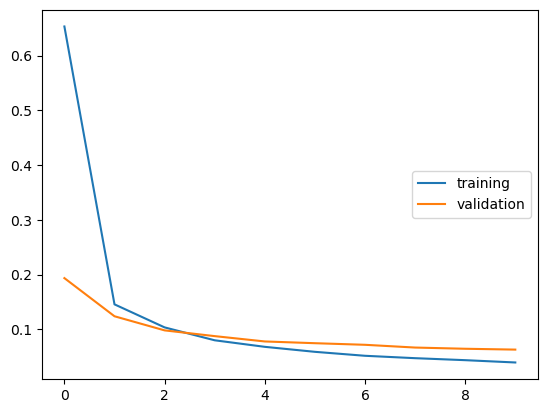

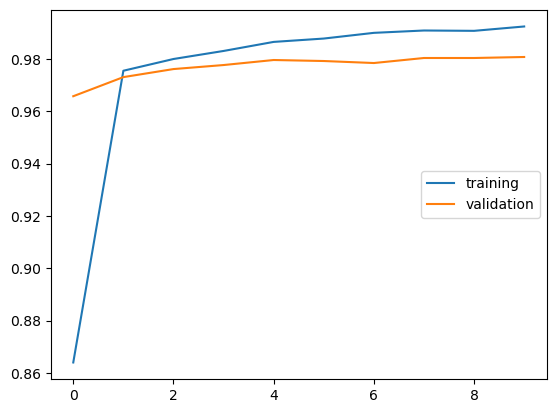

In [69]:
# 5. Plot the loss and accuracy curves.
# TODO nice plots
plt.plot(range(MAX_EPOCH), train_losses_resnet34)
plt.plot(range(MAX_EPOCH), val_losses_resnet34)
plt.legend(['training', 'validation'], loc='center right')

plt.show()

plt.plot(range(MAX_EPOCH), train_accs_resnet34)
plt.plot(range(MAX_EPOCH), val_accs_resnet34)
plt.legend(['training', 'validation'], loc='center right')

plt.show()


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [70]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [ ]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 65
INIT_LR = 0.001
BATCH_SIZE = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 
LOSS_RATIO = 

In [52]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = torchvision.models.resnet18(weights=None)


In [59]:
# 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = torch.load("../models/resnet34checkpoint.pkl", weights_only=False)
resnet34.eval()
print("")

In [9]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = 
scheduler = 

In [ ]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []


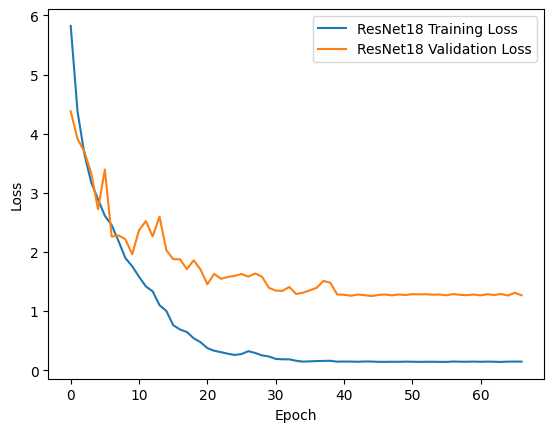

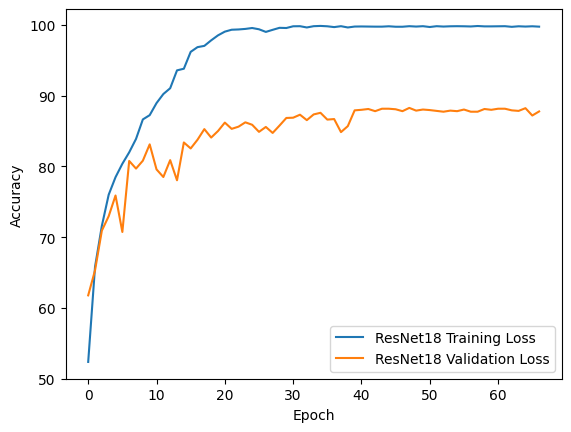

In [11]:
# TODO: 6. Plot the loss and accuracy curves.



# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = 


In [31]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []


In [ ]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = 
